Code used from this link:

https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83

GitHub Link: 
https://github.com/aditya10/ULMFiT-fastai-text-classifier/blob/master/ULMFiT_tutorial.ipynb



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

###Model set-up

In [3]:
%cd "gdrive/My Drive/Colab Notebooks"
!ls

/content/gdrive/My Drive/Colab Notebooks
20200504-193926_joe_biden_nlp.csv	Language_model.ipynb  nlp_EDA.ipynb
20200504-193926_joe_biden_nlp_subs.csv	model_language.ipynb  nlp_EDA_v2.ipynb
Extract_subtitles.ipynb			models		      nlp_export.pkl


In [4]:
# load train_cleaned.csv

filename = "20200504-193926_joe_biden_nlp_subs.csv"
train_language = pd.read_csv(filename, index_col=0)

In [5]:
train_language.head()

Bias_num  ...                                          subtitles
0         0  ...  ["who hasn't been shocked by a recent electric...
1         0  ...  ["you're one of the greatest con men of all ti...
2         0  ...  ["if you thought the insults hold between Nort...
3         0  ...  ["bravery courage defiance heartbreak they're ...
4         0  ...                                                NaN

[5 rows x 6 columns]

In [ ]:
#combine columns. Fastai only works with 1 text column
#train_language['text'] = train_language['title'] + " " + train_language['description']

In [6]:
#drop columns that will not be used.
train_language.drop(['title', 'description', 'channel', 'id'], inplace=True, axis=1)

In [7]:
#check for NAs
train_language.isna().sum()

Bias_num       0
subtitles    112
dtype: int64

In [8]:
#drop NAs
train_language.dropna(inplace=True)

In [9]:
#make sure no NAs
train_language.isna().sum()

Bias_num     0
subtitles    0
dtype: int64

In [11]:
#length of dataframe
len(train_language)

743

In [10]:
train_language.head()

Bias_num                                          subtitles
0         0  ["who hasn't been shocked by a recent electric...
1         0  ["you're one of the greatest con men of all ti...
2         0  ["if you thought the insults hold between Nort...
3         0  ["bravery courage defiance heartbreak they're ...
5         0  ["Jeffrey Epstein was a billionaire New York b...

In [12]:
#create train and test split
df_trn, df_val = train_test_split(train_language, stratify = train_language['Bias_num'], test_size = 0.3, random_state=42)
df_trn.shape, df_val.shape

((520, 2), (223, 2))

###Pre-processing language model

In [13]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [14]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [15]:
# check out data
data_clas.show_batch()

In [ ]:
#data_clas.save("/content/gdrive/My Drive/language_models/databunch/TextClasDataBunch.pkl") 

In [ ]:
#data_lm.save("/content/gdrive/My Drive/language_models/databunch/TextLMDataBunch.pkl")

### Language model

In [16]:
# train language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
# find the optimal learning rate to train our language model on
#learn.lr_find()
#learn.recorder.plot(suggestion=True)
#min_grad_lr = learn.recorder.min_grad_lr

Probability to predict next word correctly stands at 50%. That's pretty good.

In [17]:
# let’s use this learning rate to train the language model
learn.fit_one_cycle(10, 1e-3)

Unfreezing all layers increases accuracy of predicting the next word correctly to 62%, which is insanely good.

In [18]:
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

In [19]:
#save the language model encoder so that we can load it later in our classifier
learn.save_encoder("ft_enc")

### Language classifier

In [ ]:
#set-up classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])
learn.load_encoder('ft_enc')

In [21]:
#train classifier for 10 epochs
learn.fit_one_cycle(10)

In [22]:
#save model weights
learn.save('language_classifier')

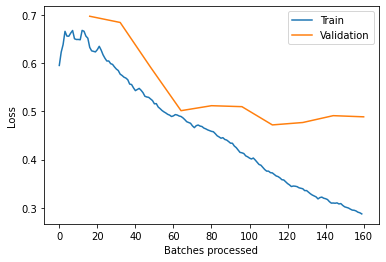

In [23]:
#inspect losses.
learn.recorder.plot_losses()

In [24]:
# unfreezing weights and training the rest of the NN
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

In [ ]:
#export language classifier for prediction
learn.export(file = "nlp_export.pkl")

###Confusion matrix

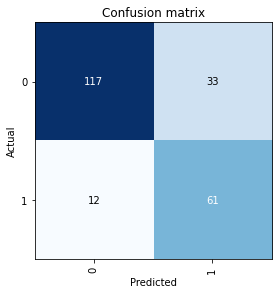

In [25]:
# create confusion matrix
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [27]:
train_language['Bias_num'].sum()/len(train_language)

0.32570659488559894